In [2]:
import dolfin as dl
import matplotlib.pyplot as plt
import mshr
import numpy as np
from scipy.optimize import fsolve
%matplotlib inline

In [3]:
# Read a Unit Square Mesh
def square_mesh(MeshDensity, Length):
    domain = mshr.Rectangle(dl.Point(-Length/2, -Length/2), dl.Point(Length/2, Length/2))
    mesh = mshr.generate_mesh(domain, MeshDensity); geoDimension = mesh.topology().dim()
    geoDimension = mesh.topology().dim()
    return mesh, geoDimension

def boundary_condition(mesh, geoDimension, V):
    # define boundary subdomains
    tol = 1e-8

    class Left(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[0], -Length/2, tol)

    class Right(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[0], +Length/2, tol)

    class Top(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[1], Length/2, tol)

    class Bottom(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[1], -Length/2, tol)

    left = Left()
    right = Right()
    top = Top()
    bottom = Bottom()
    # mark boundary subdomains with markers 1, 2, 3, 4
    boundaries = dl.MeshFunction("size_t", mesh, geoDimension-1, 0)
    boundaries.set_all(0)
    left.mark(boundaries, 1)
    right.mark(boundaries, 2)
    top.mark(boundaries, 3)
    bottom.mark(boundaries, 4)

    # compile surface integration
    ds = dl.Measure('ds', domain=mesh, subdomain_data=boundaries)
    
    # fix extra point to rule out rigid body motion
    tol = 1e-6
    def fixPoint(x, on_boundary):
        return dl.near(x[0], -Length/2, tol) and dl.near(x[1], -Length/2, tol)
    bc_left_X  = dl.DirichletBC(V.sub(0), dl.Constant(0.0), left)
    bc_left_Y  = dl.DirichletBC(V.sub(1), dl.Constant(0.0), fixPoint, method="pointwise")

    bcs = [bc_left_X, bc_left_Y]
    return ds, bcs

def epsilon(u):
    return dl.sym(dl.grad(u))
# elastic constants
E = 200; nu = 0.3
# convert to Lame constants
mu = E/2/(1+nu); lmbda = E*nu/(1+nu)/(1-2*nu)
# convert to bulk and shear modulus
mu = E/2/(1+nu); kappa = E/(1-2*nu)/3 #E/(1-2*nu)
# nonlinear parameters:
n = 1.5; s0 = 1.0; e0 = 0.005;
    
def nonlinear_plain_strain(mesh, geoDimension, traction):
   
    #define vector function space, function u, and test function v
    
    u  = dl.Function(V)
    v  = dl.TestFunction(V)
    du = dl.TrialFunction(V)
    
    ds, bcs = boundary_condition(mesh, geoDimension, V)
    # define strain

    
    # LINEAR STRAIN ENERGY DENSITY, rule sigularity
    def Psi_linear(u):
        eps = epsilon(u)
        sigma = 2*mu*eps + lmbda*dl.tr(eps)*dl.Identity(geoDimension)
        return 1/2 * dl.inner(sigma, eps) 

    # define traction 
    T = dl.Constant(0.1)
    # initialize vector to be 0
    u.vector()[:] = 0.0
    # minimize potential energy
    Pi = Psi_linear(u) * dl.dx - T*u[0]*ds(2)
    Res = dl.derivative(Pi, u, v)
    dl.solve(Res == 0, u, bcs)
    # calculate potential energy
    #print("Linear Elasticity, Potential Energy = ", dl.assemble(Pi))
    
    # POWER LAW NONLINEAR ELASTIC MATERIAL
    def Psi_nonlinear(u):
        eps = epsilon(u)
        ev = dl.tr(eps) + 0
        e = eps - ev * dl.Identity(geoDimension)/3
        e_e2 =  (dl.inner(e, e) + (-1/3.0*ev)**2 ) * 2/3
        m = (n+1)/n/2;
        return kappa/2.*ev**2 + 1/(2 * m) * s0*e0*(e_e2/e0**2)**m 

    # larger traction
    T.assign(traction)

    # minimize potential energy
    Pi = Psi_nonlinear(u) * dl.dx - T*u[0]*ds(2)
    Res = dl.derivative(Pi, u, v)
    dl.solve(Res == 0, u, bcs)

    # calculate potential energy
    #print("Nonlinear Elasticity, Potential Energy = ", dl.assemble(Pi))
    return u

def analytical(u, tens):
    eps_dl = epsilon(u)
    VS = dl.FunctionSpace(mesh, "CG", 1)
    e_00 = dl.project(eps_dl[0, 0], VS).vector()[0]
    e_01 = dl.project(eps_dl[0, 1], VS).vector()[0]
    e_11 = dl.project(eps_dl[1, 1], VS).vector()[0]

    ev = e_00 + e_11 + 0
    eps = np.array([[e_00, e_01, 0],[e_01, e_11, 0], [0, 0, 0]])
    e = eps - ev/3*np.eye(3)
    e_e = np.sqrt(np.sum(e * e) * 2/3)
    sigma = kappa*ev*np.eye(3) + 2/3 * s0/e0 * (e_e/e0)**(-(n-1)/n) * e
    
    def func(x):
        ev = x[0] + x[1]
        e_e = np.sqrt(2/3*((x[0]-ev/3)**2 + (x[1] - ev/3)**2 + (ev/3)**2))
        alpha = 2/3 * s0/e0 * (e_e/e0)**(-(n-1)/n)
        return [kappa*ev + alpha*(x[0]-ev/3) - tens,
                kappa*ev + alpha*(x[1]-ev/3) - 0,
                kappa*ev + alpha*(0-ev/3)    - x[2]]

    e_00, e_11, sigma_22 = fsolve(func, [e_00+0.001, e_11+0.001, sigma[2,2]+0.1])
    return e_00

In [4]:
MeshDensity = 10; Length = 1;
mesh, geoDimension = square_mesh(MeshDensity, Length)
#dl.plot(mesh)
#u = nonlinear_plain_strain(mesh, geoDimension, 1)
#dl.plot(u, mode="displacement")

elementDegree = 1
V  = dl.VectorFunctionSpace(mesh, 'Lagrange', elementDegree)
ds, bcs = boundary_condition(mesh, geoDimension, V)

5.762647295055016e-25 [4.76412638e-07 7.40549064e-07 1.14738851e-06 1.77193989e-06
 2.72766025e-06 4.18583936e-06 6.40475387e-06 9.77361626e-06
 1.48790288e-05 2.26058362e-05 3.42908219e-05 5.19579943e-05
 7.86804729e-05 1.19139719e-04 1.80493693e-04 2.73730416e-04
 4.15786669e-04 6.32876146e-04 9.65733953e-04 1.47790385e-03
 2.26886569e-03 3.49487473e-03 5.40210639e-03 8.37946054e-03
 1.30428095e-02 2.03695855e-02 3.19140243e-02 5.01517331e-02
 7.90317438e-02 1.24861624e-01]


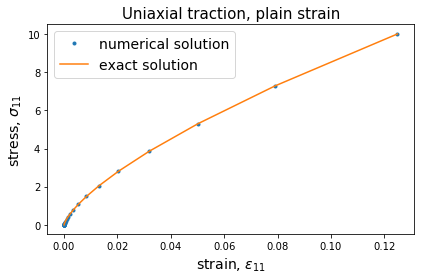

In [5]:
# Strain-Strss Curve
#ts = np.linspace(0.1, 1, 20)
ts = np.logspace(-3, np.log10(10), 30)
us = []
e_analytical = []
for t in ts:
    u = nonlinear_plain_strain(mesh, geoDimension, t)
    us.append(dl.assemble(u[0]*ds(2)))
    e_analytical.append(analytical(u,t))

us = np.array(us)
e_analytical = np.array(e_analytical)

error = np.mean((us-e_analytical)**2)
print(error,e_analytical)

plt.plot(us, ts, '.', label="numerical solution")
plt.plot(e_analytical * Length, ts, label="exact solution")

plt.legend(fontsize=14)
plt.xlabel("strain, $\\epsilon_{11}$", fontsize=14);
plt.ylabel("stress, $\\sigma_{11}$", fontsize=14);
plt.title("Uniaxial traction, plain strain", fontsize=15)
plt.tight_layout()
plt.savefig("stress-strain-curve.png")

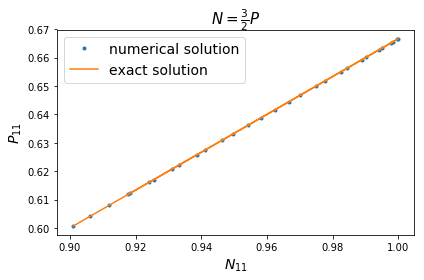

In [6]:
# N-P Curve
ts = np.logspace(-3, np.log10(10), 30)
N_11 = []
P_11 = []

y_e = []
x_s = []
for t in ts:
    u = nonlinear_plain_strain(mesh, geoDimension, t)
    eps_dl = epsilon(u)
    VS = dl.FunctionSpace(mesh, "CG", 1)
    e_00 = dl.project(eps_dl[0, 0], VS).vector()[0]
    e_01 = dl.project(eps_dl[0, 1], VS).vector()[0]
    e_11 = dl.project(eps_dl[1, 1], VS).vector()[0]

    ev = e_00 + e_11 + 0
    eps = np.array([[e_00, e_01, 0],[e_01, e_11, 0], [0, 0, 0]])
    e = eps - ev/3*np.eye(3)
    e_e = np.sqrt(np.sum(e * e) * 2/3)
    sigma = kappa*ev*np.eye(3) + 2/3 * s0/e0 * (e_e/e0)**(-(n-1)/n) * e
    p = (sigma[0,0] + sigma[1,1] + sigma[2,2])/3
    s = sigma - p*np.eye(3)
    s_e = np.sqrt(np.sum(s*s)*3/2)
    N = 3/2/s_e*s
    P = 2/3/e_e*e
    
    N_11.append(N[0,0])
    P_11.append(P[0,0])
    
    y_e.append(e_e/e0)
    x_s.append(s_e/s0)

P_11 = np.array(P_11)
plt.plot(N_11, P_11, '.', label="numerical solution")
plt.plot(3/2*P_11, P_11, label="exact solution")

plt.legend(fontsize=14)
plt.xlabel(r"$N_{11}$", fontsize=14);
plt.ylabel(r"$P_{11}$", fontsize=14);
plt.title(r"$N = \frac{3}{2}P$", fontsize=15)
plt.tight_layout()
plt.savefig("N-P-Curve.png")  


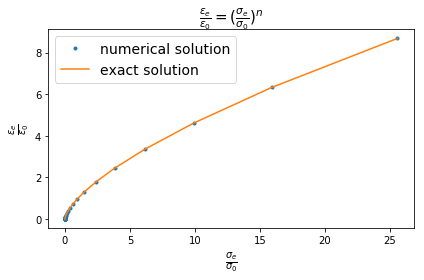

In [7]:
x_s = np.array(x_s)
plt.plot(y_e, x_s, '.', label="numerical solution")
plt.plot(x_s**n, x_s, label="exact solution")

plt.legend(fontsize=14)
plt.xlabel(r"$\frac{\sigma_{e}}{\sigma_{0}}$", fontsize=14);
plt.ylabel(r"$\frac{\epsilon_{e}}{\epsilon_{0}}$", fontsize=14);
plt.title(r"$\frac{\epsilon_{e}}{\epsilon_{0}} = {(\frac{\sigma_{e}}{\sigma_{0}})}^{n}$", fontsize=15)
plt.tight_layout()
plt.savefig("e_e-s_e-curve.png")  

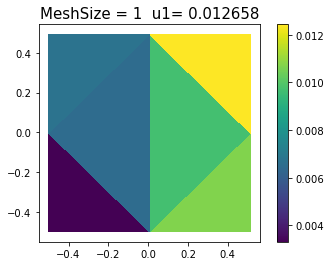

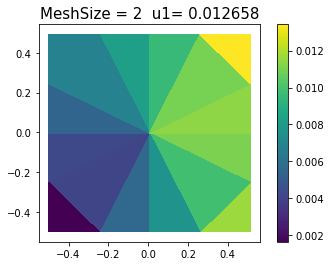

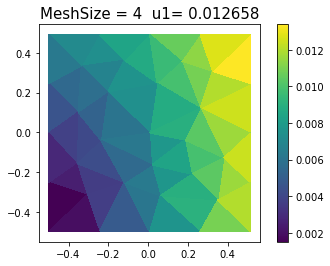

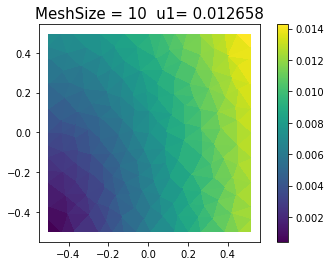

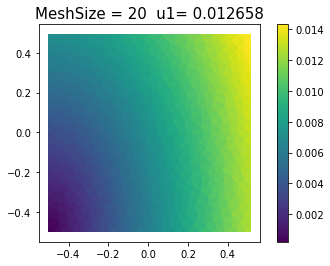

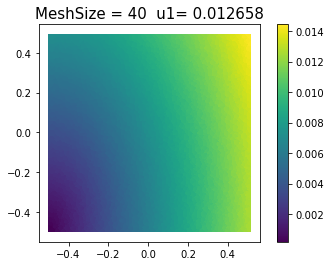

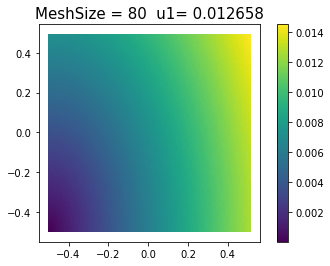

In [8]:
MDs = [1,2,4,10,20,40,80]
Length = 1
traction = 2

us = []
for md in MDs:
    mesh, geoDimension = square_mesh(md, Length) 
    elementDegree = 1
    V  = dl.VectorFunctionSpace(mesh, 'Lagrange', elementDegree)
    ds, bcs = boundary_condition(mesh, geoDimension, V)
    u = nonlinear_plain_strain(mesh, geoDimension, 2)
    us.append(dl.assemble(u[0]*ds(2)))
    plt.figure()
    #dl.plot(mesh)
    fig = dl.plot(u, mode="displacement")
    plt.colorbar(fig)
    plt.title(("MeshSize = %d"%md)+r"  u1"+"= %.6f"%(us[-1]), fontsize=15)
    plt.savefig("./Lectures/mesh/"+("density-%d"%md)+".png")  

### 5. 图线：上面只是是一个例子，得到应力应变曲线。你是否可以得到其他的图线来表征这个问题的解答？并与精确解做比较；其他可以做的事情，例如加密网格比较误差等，请尽可能多的得到一些有意义的结果并放在报告中 